# **D208 Performance Assessment 1:** Multiple Linear Regression  

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Churn  
---

### *Research Question*  

Which customer characteristics predict high bandwidth consumption?

## Initialization
---

In [1]:
#import needed libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

#allow pd.describe to show all columns of the data frame [In-Text Citation: (Ray, 2020)]
pd.options.display.max_columns = None 

#Initialize some lists
survey_answers = [1,2,3,4,5,6,7,8]

# Starting explanatory variables
numerical_variables = ['Age','Income','Children','Tenure','Outage_sec_perweek','MonthlyCharge']
categorical_variables = ['Marital','Gender']
yes_no_variables = ['Techie','Port_modem','Tablet','Phone','Multiple','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
survey_variables = ['Item1','Item2','Item3','Item4','Item5','Item6','Item7','Item8']
X_full = numerical_variables + categorical_variables + yes_no_variables + survey_variables
X_reduced = []

#  Dependent variable
y = ['Bandwidth_GB_Year']

#load church_missing_data.csv
df = pd.read_csv('churn_clean.csv', keep_default_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

## Cleaning
---

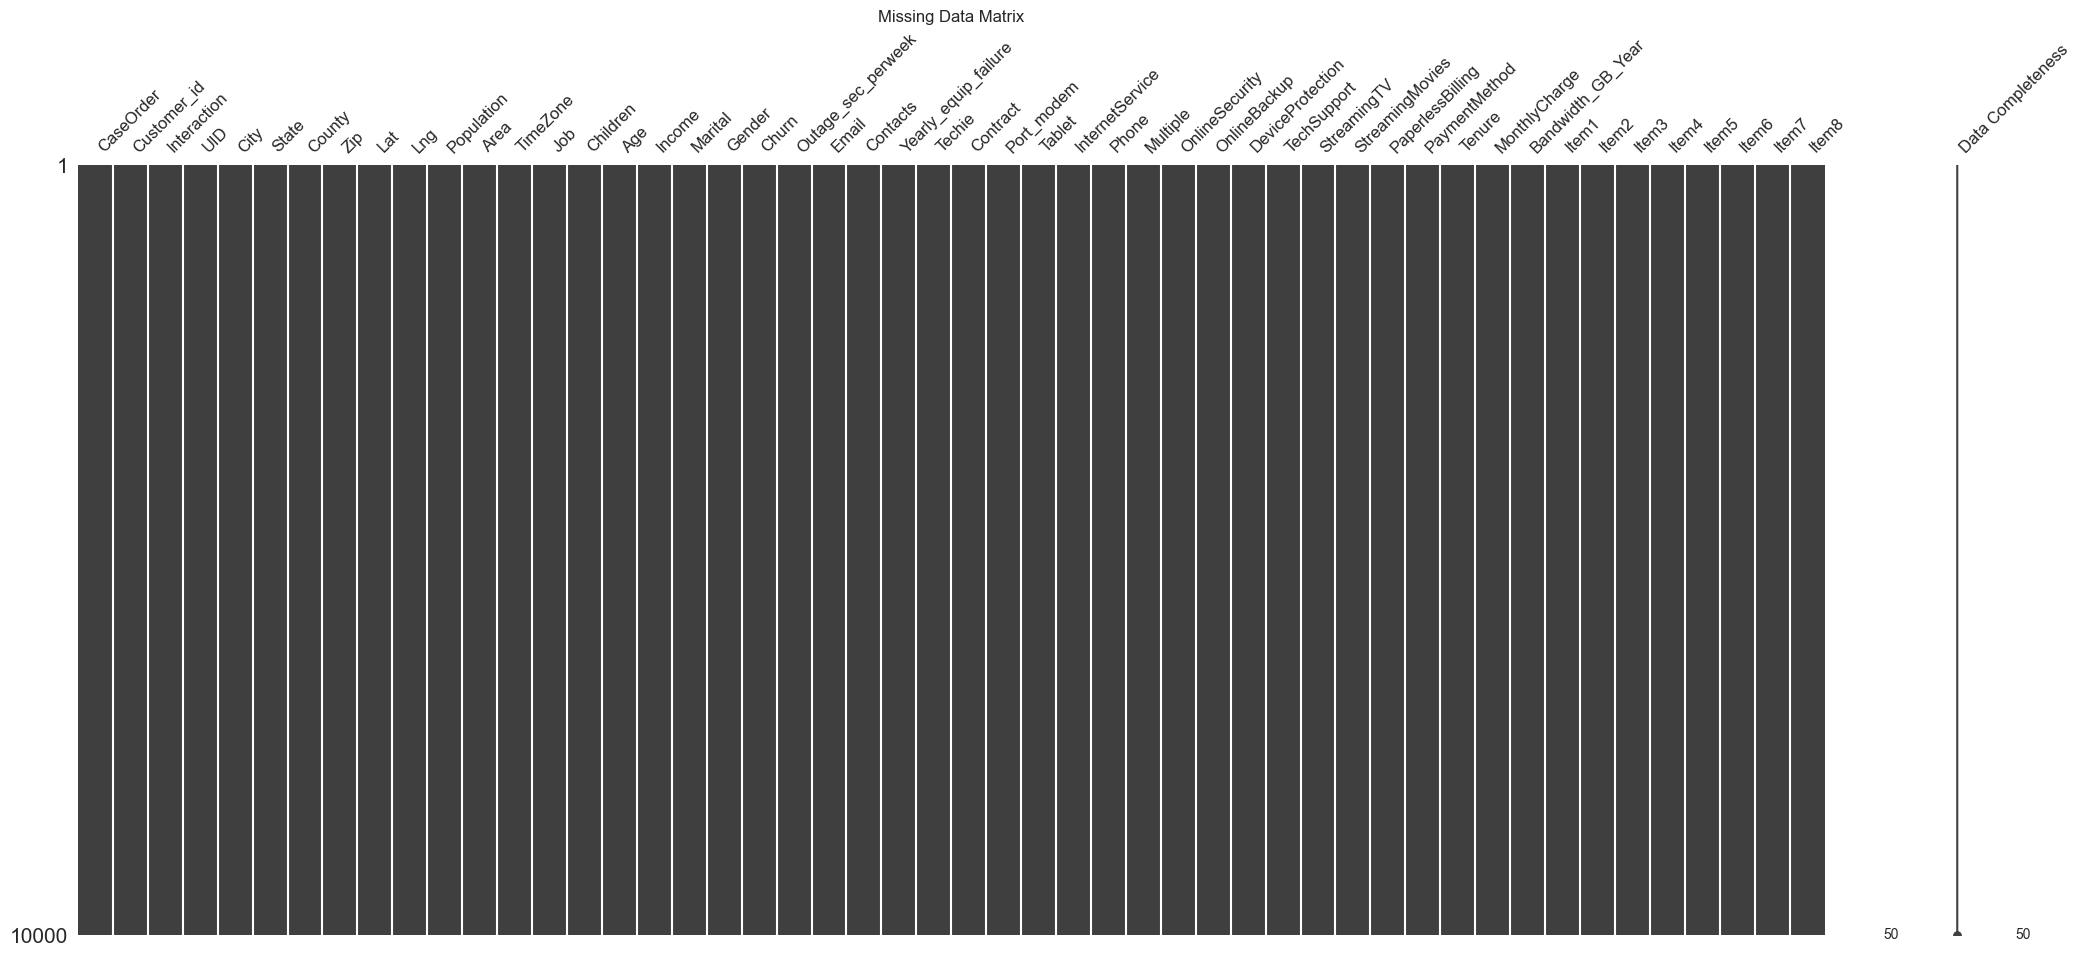

In [2]:
# Check missing data
msno.matrix(df, fontsize = 12, labels=True)
plt.title('Missing Data Matrix')
plt.show()

In [3]:
# Check survey question validity
print(df[survey_variables][~df[survey_variables].isin(survey_answers)].count()) 

Item1    0
Item2    0
Item3    0
Item4    0
Item5    0
Item6    0
Item7    0
Item8    0
dtype: int64


In [4]:
#Check values in yes/no variables
print(df[yes_no_variables][~df[yes_no_variables].isin(['Yes','No'])].count())


Techie              0
Port_modem          0
Tablet              0
Phone               0
Multiple            0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [5]:
#Detect potential outliers
df_z = (df[numerical_variables] - df[numerical_variables].mean())/df[numerical_variables].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    minval, maxval = df[col].min(), df[col].max()
    print('Likely outlier for {0:<20}\t Count: {1:7d} ({2:5.2%} of observations)\tMin: {3:>9.2f}\tMax: {4:>9.2f}'.format(col,cnt,cnt/10000,minval,maxval))

Likely outlier for Income              	 Count:     145 (1.45% of observations)	Min:    348.67	Max: 258900.70
Likely outlier for Children            	 Count:     191 (1.91% of observations)	Min:      0.00	Max:     10.00
Likely outlier for Outage_sec_perweek  	 Count:      15 (0.15% of observations)	Min:      0.10	Max:     21.21


## Summary Statistics
---

In [6]:
# Dependent variable
print(df[y].describe())

       Bandwidth_GB_Year
count       10000.000000
mean         3392.341550
std          2185.294852
min           155.506715
25%          1236.470827
50%          3279.536903
75%          5586.141370
max          7158.981530


In [7]:
# Independent numerical variables
for col in numerical_variables :
    print(f'{col} :')
    print(df[col].describe())

Age :
count    10000.000000
mean        53.078400
std         20.698882
min         18.000000
25%         35.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64
Income :
count     10000.000000
mean      39806.926771
std       28199.916702
min         348.670000
25%       19224.717500
50%       33170.605000
75%       53246.170000
max      258900.700000
Name: Income, dtype: float64
Children :
count    10000.0000
mean         2.0877
std          2.1472
min          0.0000
25%          0.0000
50%          1.0000
75%          3.0000
max         10.0000
Name: Children, dtype: float64
Tenure :
count    10000.000000
mean        34.526188
std         26.443063
min          1.000259
25%          7.917694
50%         35.430507
75%         61.479795
max         71.999280
Name: Tenure, dtype: float64
Outage_sec_perweek :
count    10000.000000
mean        10.001848
std          2.976019
min          0.099747
25%          8.018214
50%         10.018560
7

In [8]:
# Independent categorical variables
for col in categorical_variables+yes_no_variables+survey_variables :
    print(df[col].value_counts())
    print(f'Mode: {df[col].mode()[0]}\n')

# Change "Never Married" to "NeverMarried" to prevent one-hot encoding problems later
df['Marital'] = df['Marital'].replace('\s+', '',regex=True)
print(df['Marital'].value_counts())


Marital
Divorced         2092
Widowed          2027
Separated        2014
Never Married    1956
Married          1911
Name: count, dtype: int64
Mode: Divorced

Gender
Female       5025
Male         4744
Nonbinary     231
Name: count, dtype: int64
Mode: Female

Techie
No     8321
Yes    1679
Name: count, dtype: int64
Mode: No

Port_modem
No     5166
Yes    4834
Name: count, dtype: int64
Mode: No

Tablet
No     7009
Yes    2991
Name: count, dtype: int64
Mode: No

Phone
Yes    9067
No      933
Name: count, dtype: int64
Mode: Yes

Multiple
No     5392
Yes    4608
Name: count, dtype: int64
Mode: No

OnlineSecurity
No     6424
Yes    3576
Name: count, dtype: int64
Mode: No

OnlineBackup
No     5494
Yes    4506
Name: count, dtype: int64
Mode: No

DeviceProtection
No     5614
Yes    4386
Name: count, dtype: int64
Mode: No

TechSupport
No     6250
Yes    3750
Name: count, dtype: int64
Mode: No

StreamingTV
No     5071
Yes    4929
Name: count, dtype: int64
Mode: No

StreamingMovies
No     5110
Y

## Visualizations
---

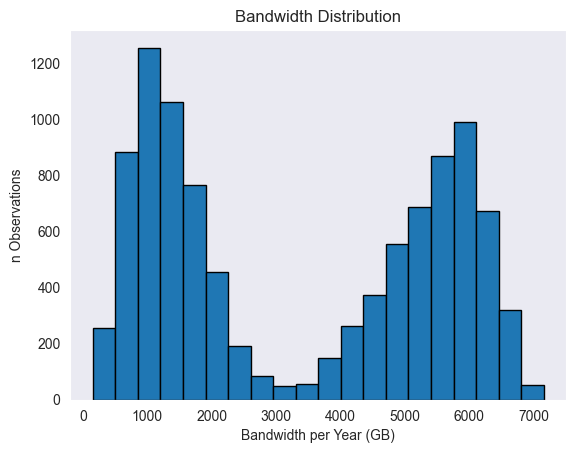

In [9]:
# Dependent variable
df.hist(y, grid=False, bins=20, edgecolor='black')
plt.xlabel('Bandwidth per Year (GB)')
plt.ylabel('n Observations')
plt.title('Bandwidth Distribution')
plt.show()

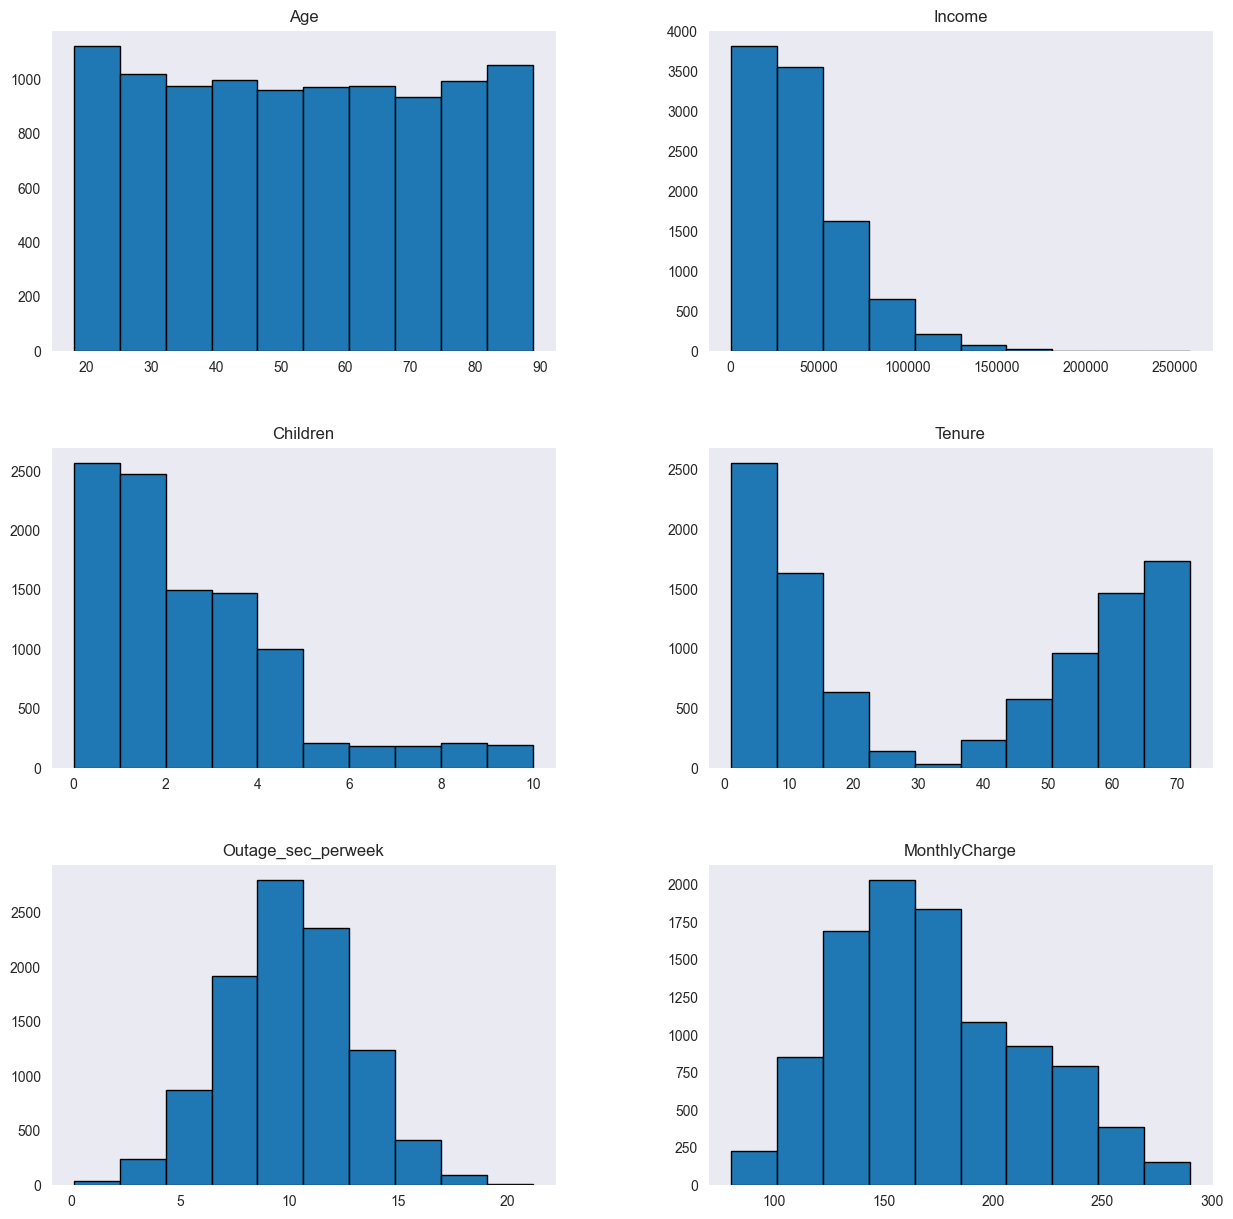

In [10]:
# Independent numeric variables univariate
df.hist(numerical_variables, grid=False, edgecolor='black', figsize=(15,15))
plt.show()

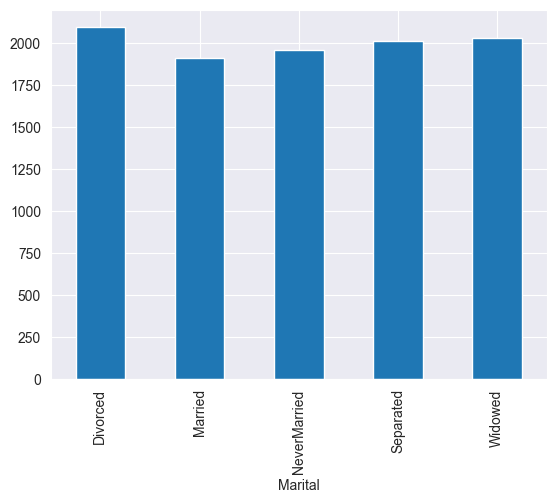

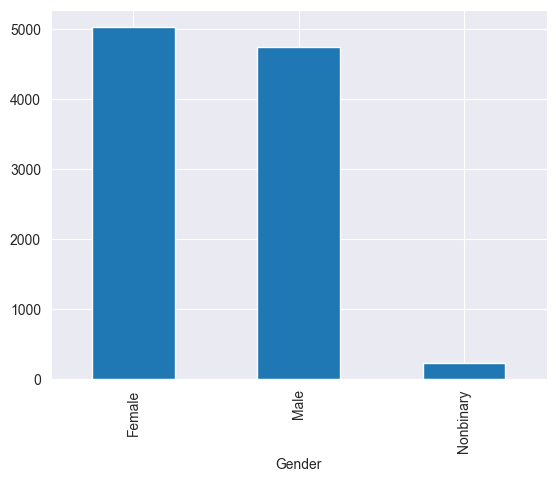

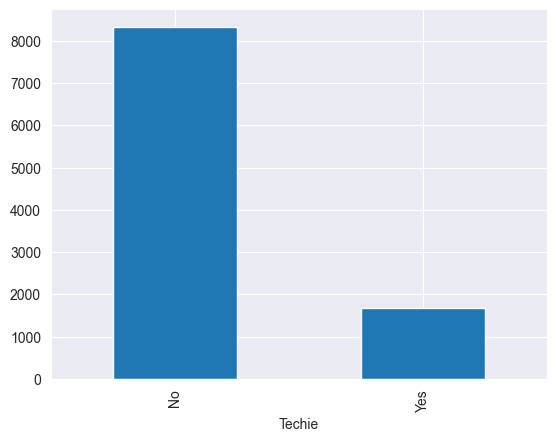

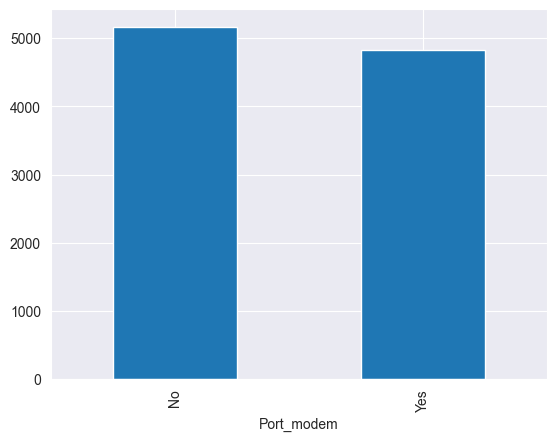

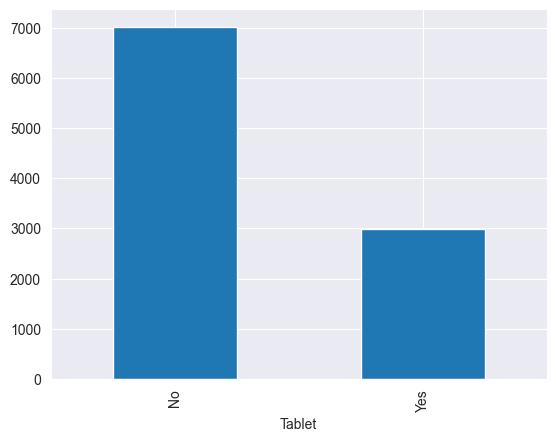

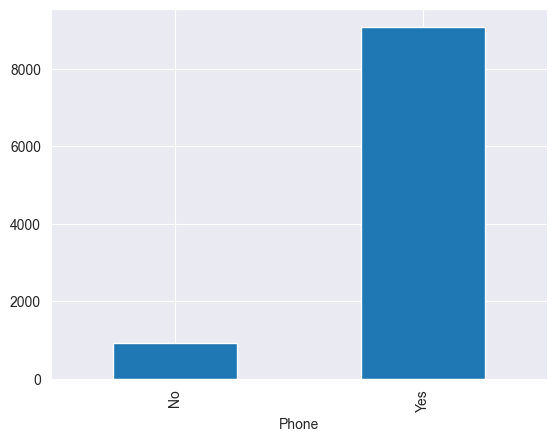

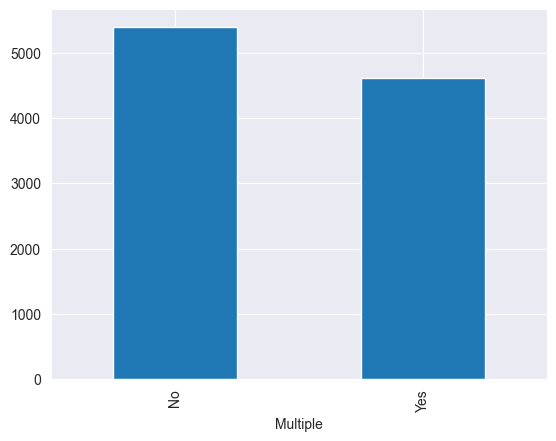

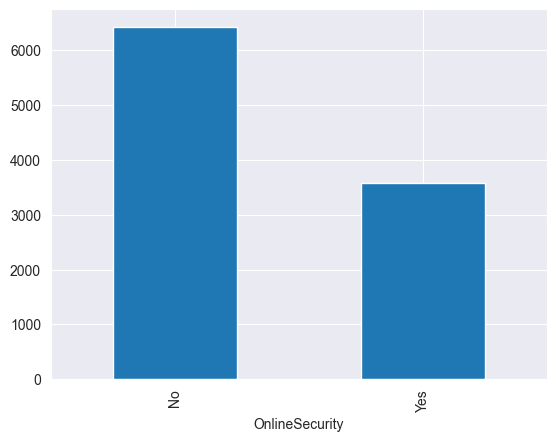

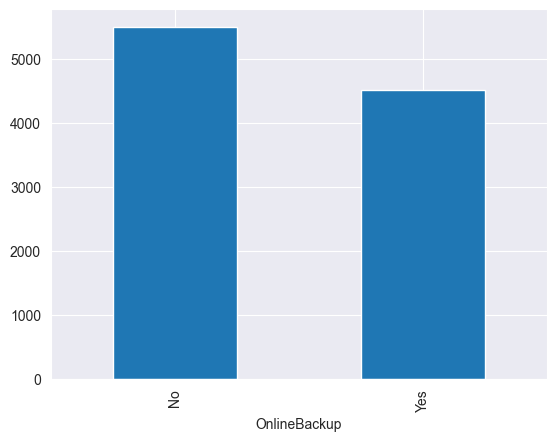

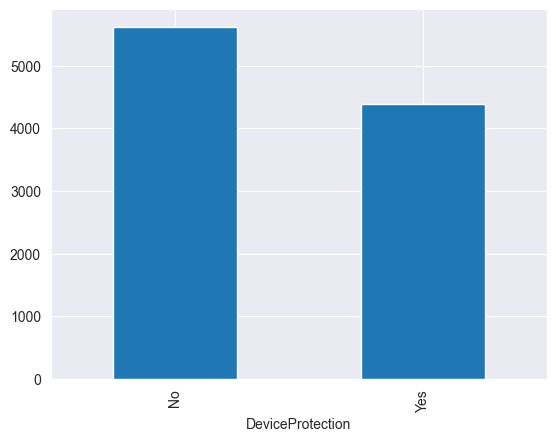

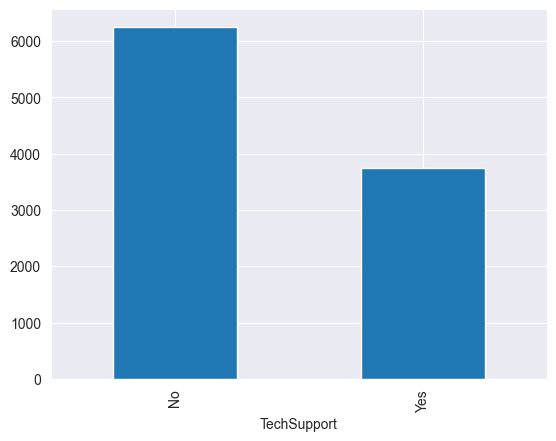

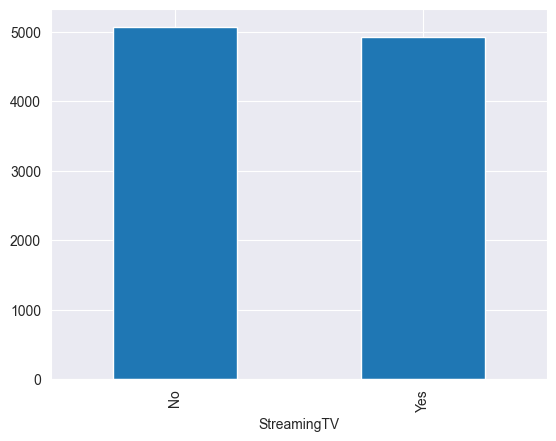

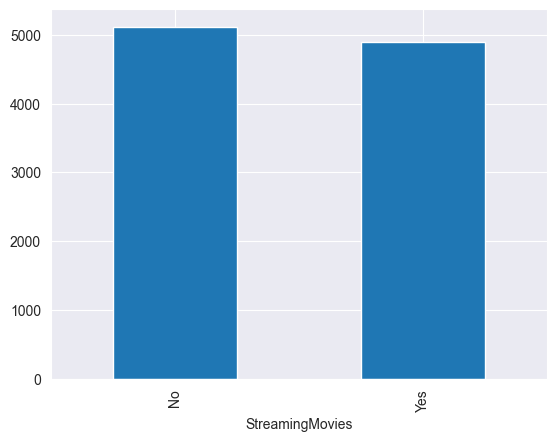

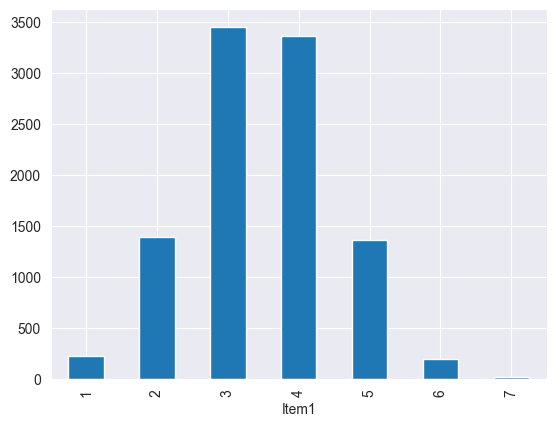

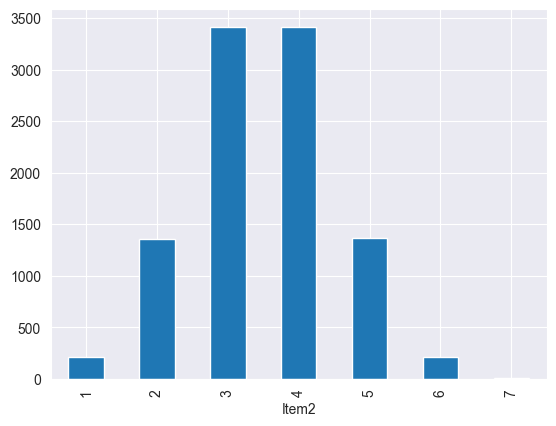

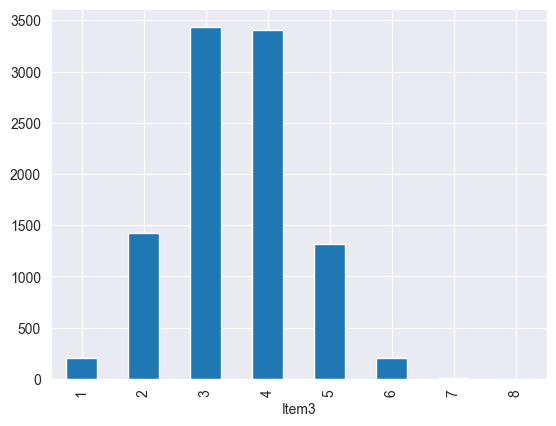

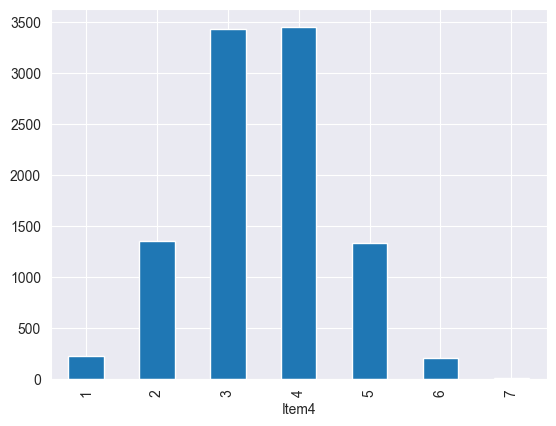

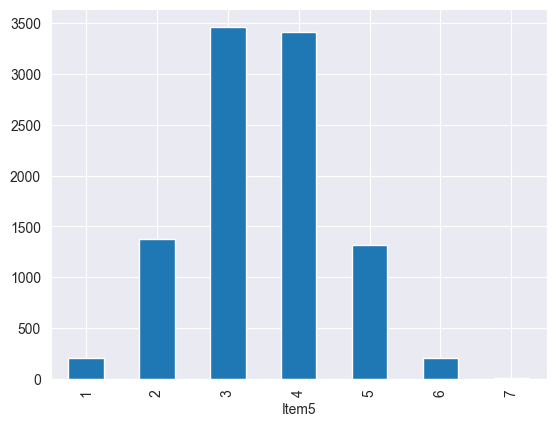

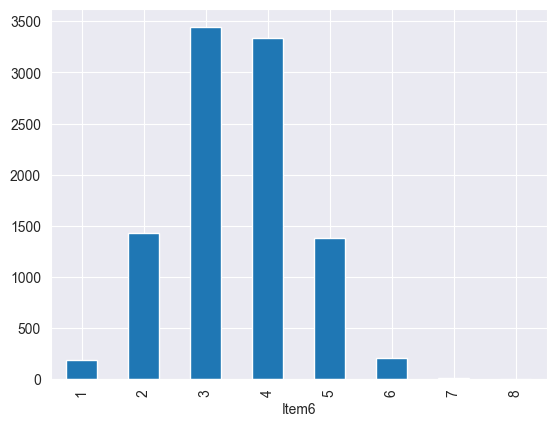

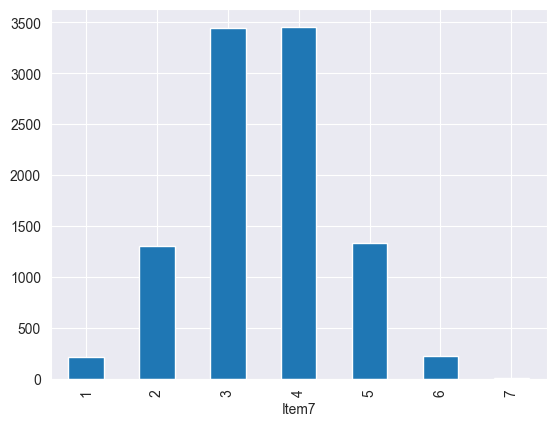

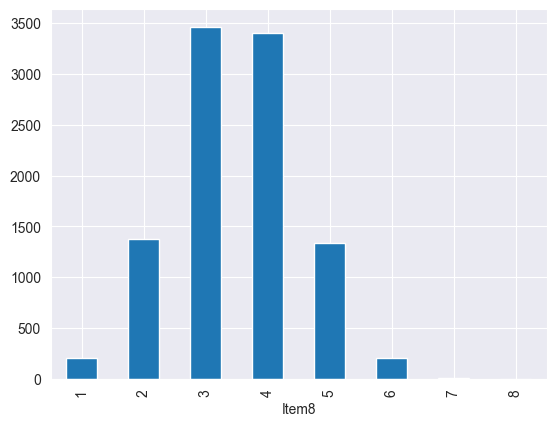

In [11]:
# Independent categorical variables univariate
for col in categorical_variables+yes_no_variables+survey_variables :
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.show()

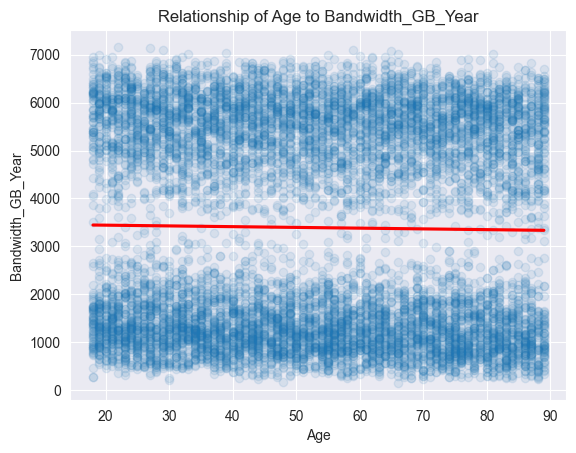

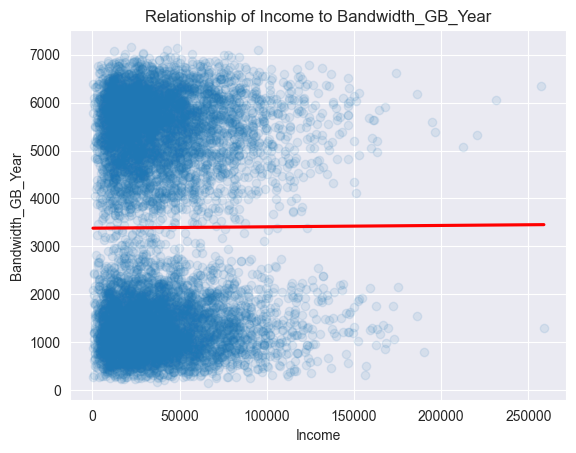

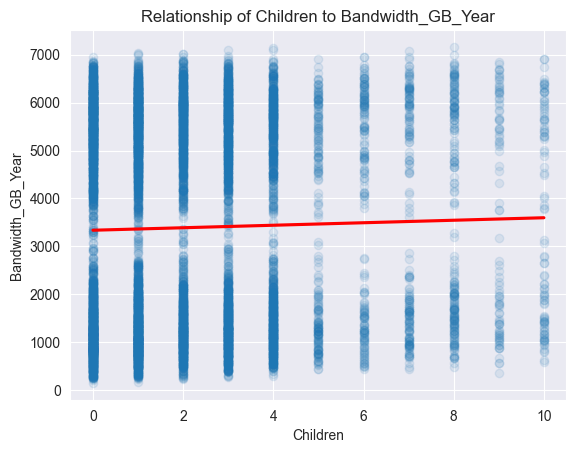

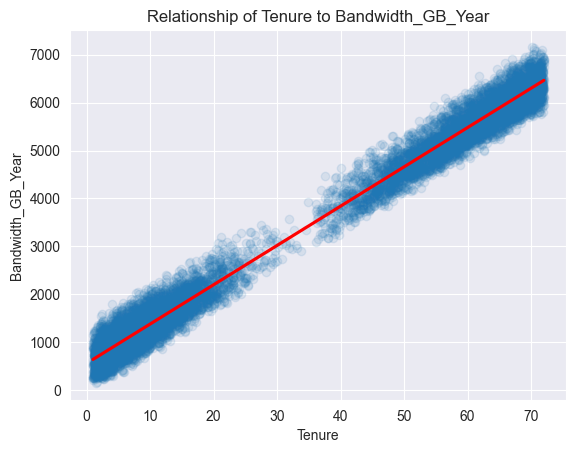

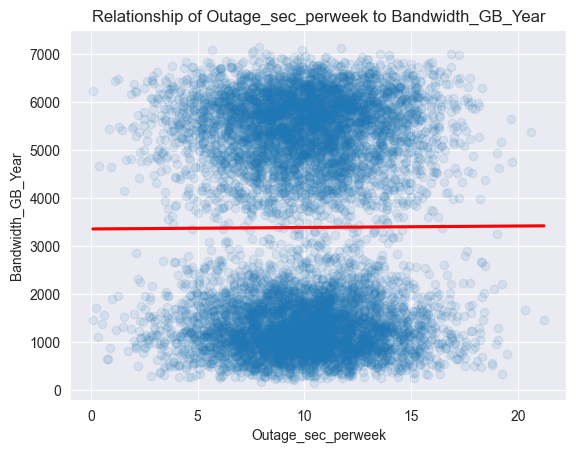

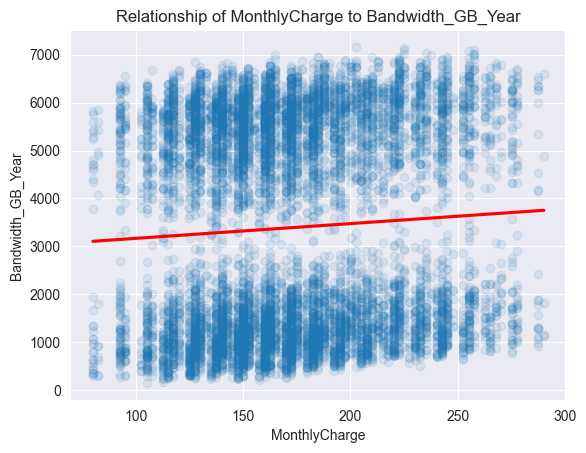

In [12]:
# Bivariate numerical
for col in numerical_variables :
    sns.regplot(data=df, x=col, y=y[0], scatter_kws={'alpha' : 1/10}, line_kws = {'color': 'red'}, ci=None)
    plt.title(f'Relationship of {col} to {y[0]}')
    plt.show()

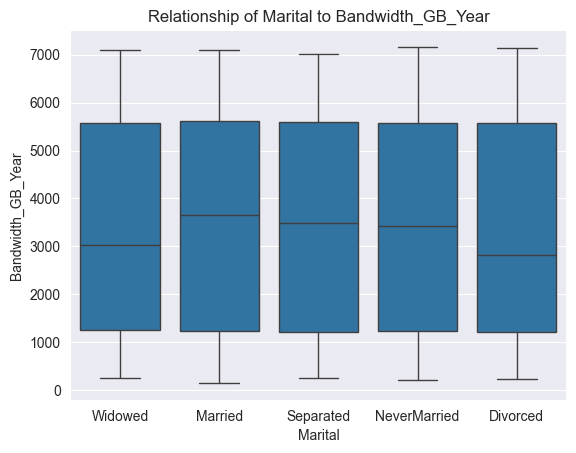

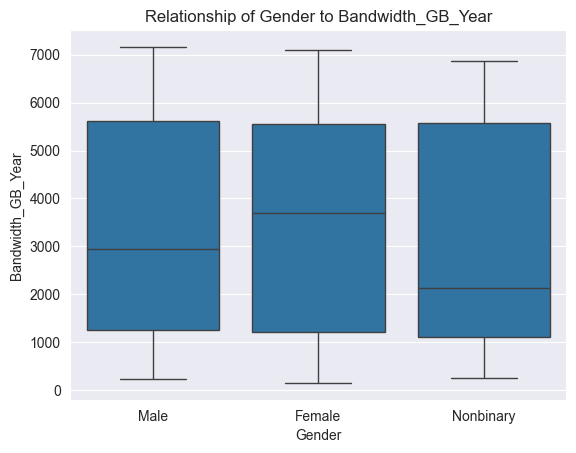

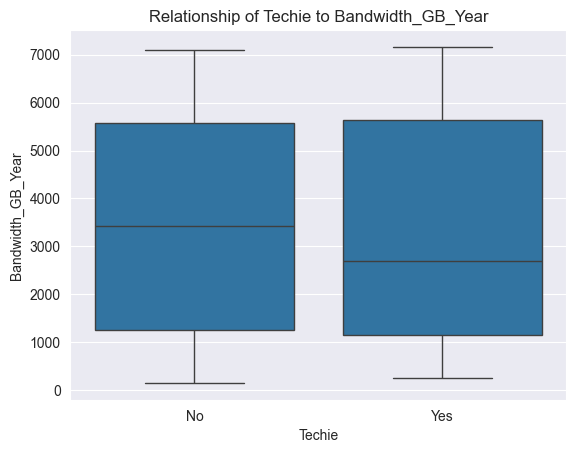

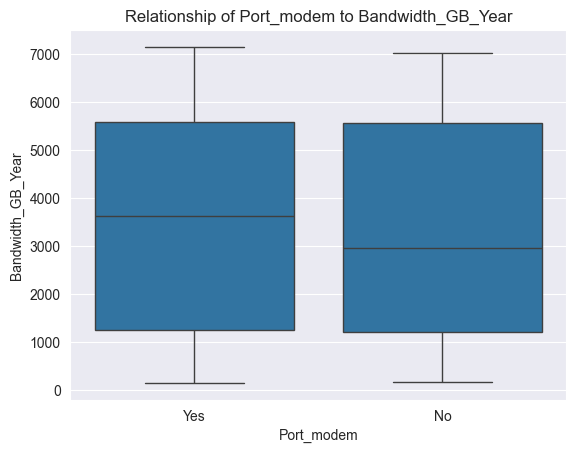

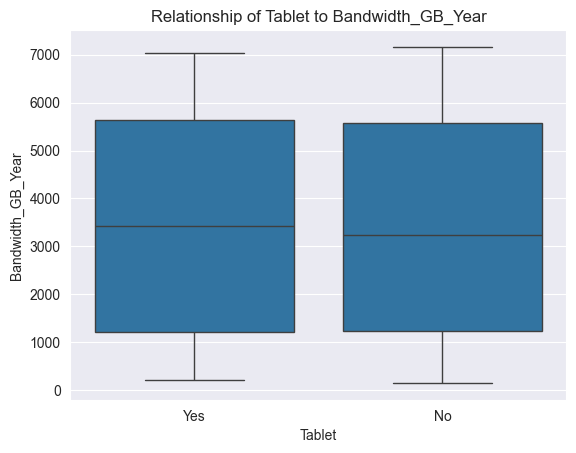

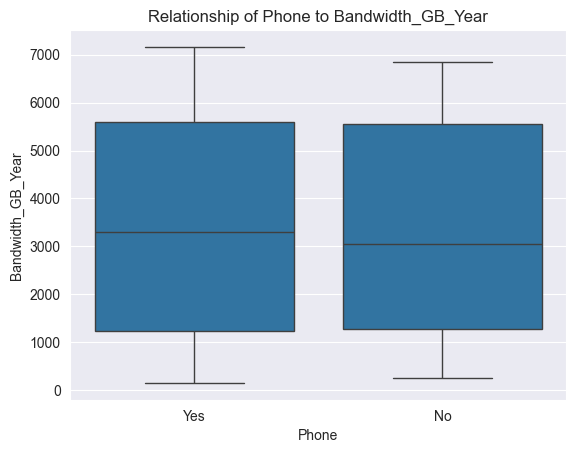

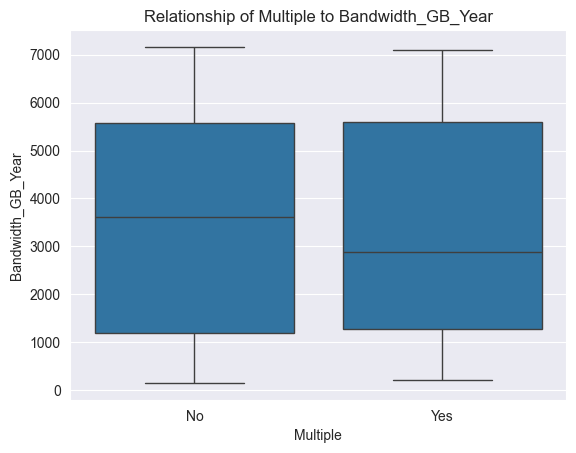

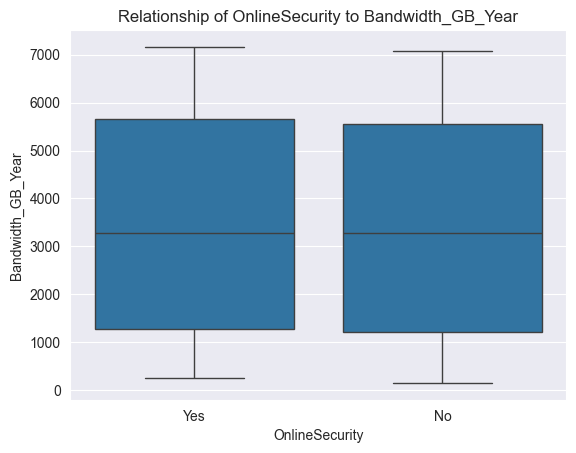

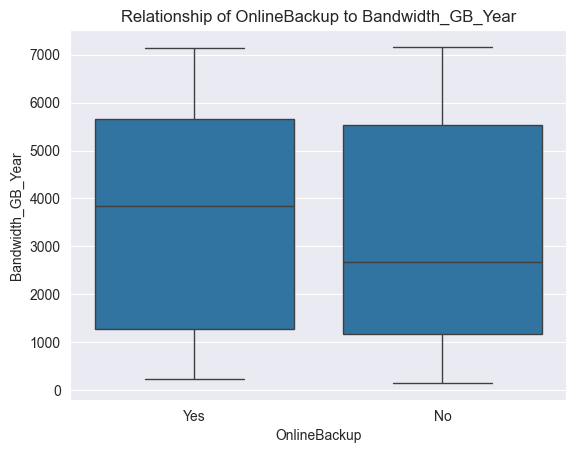

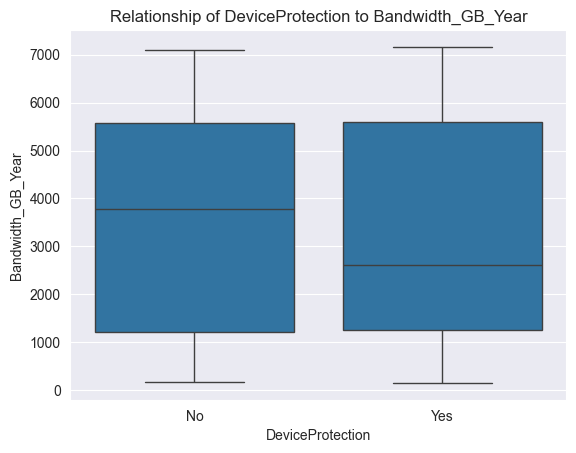

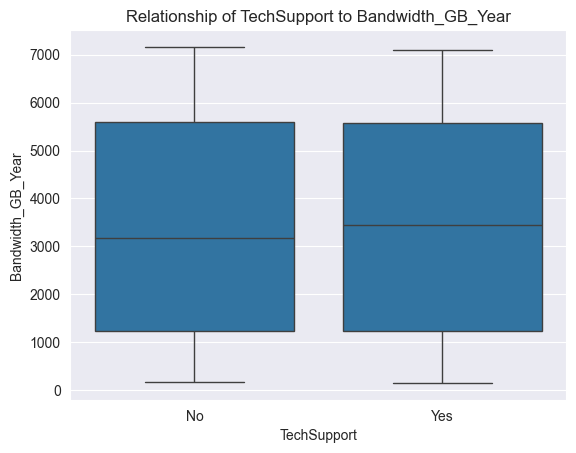

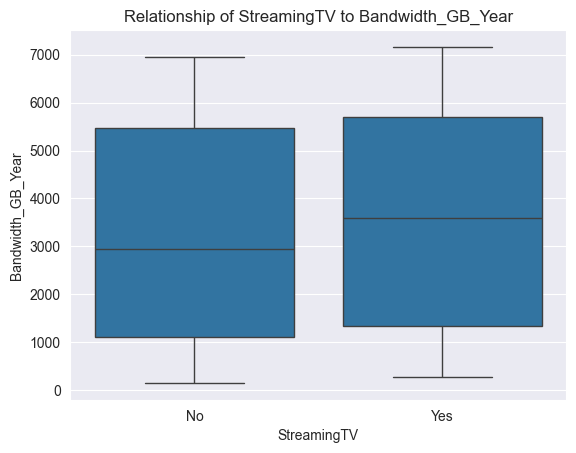

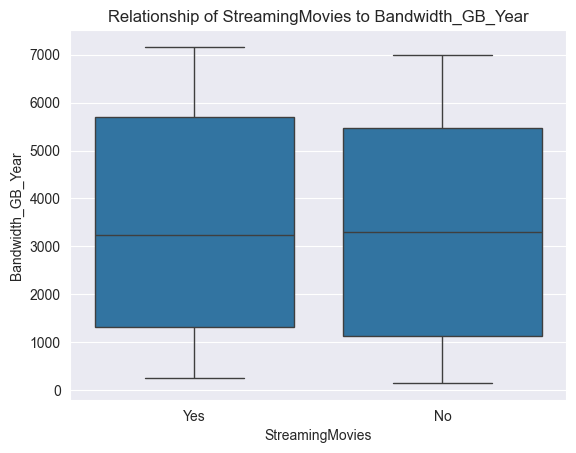

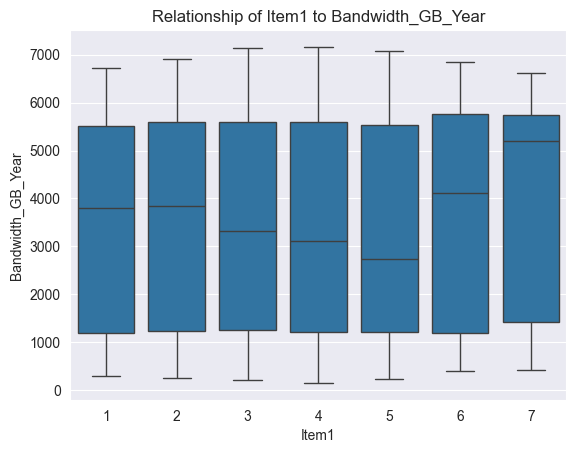

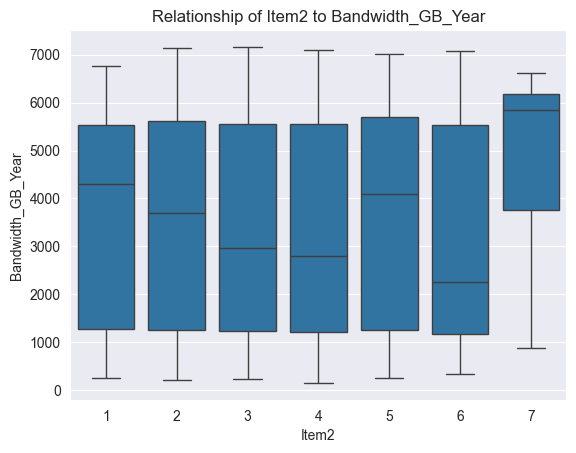

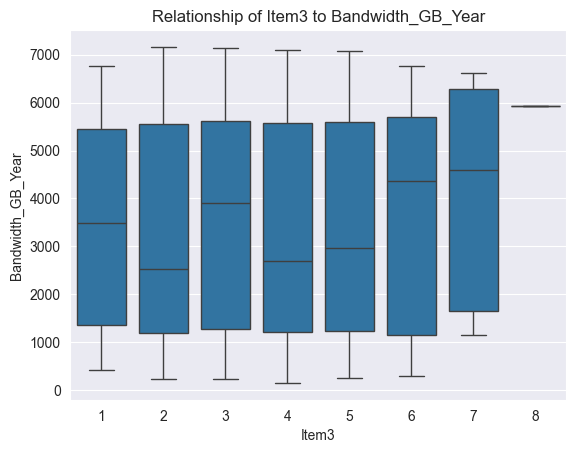

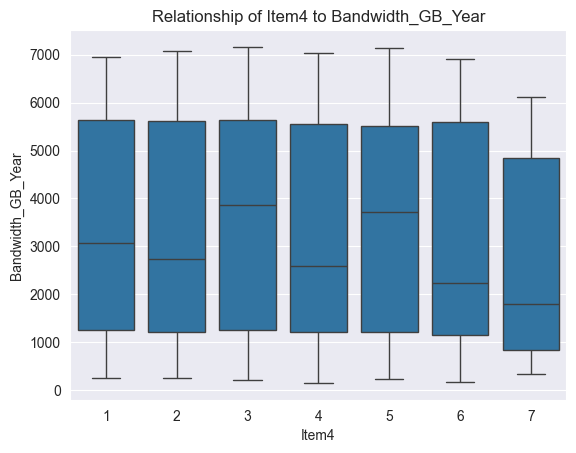

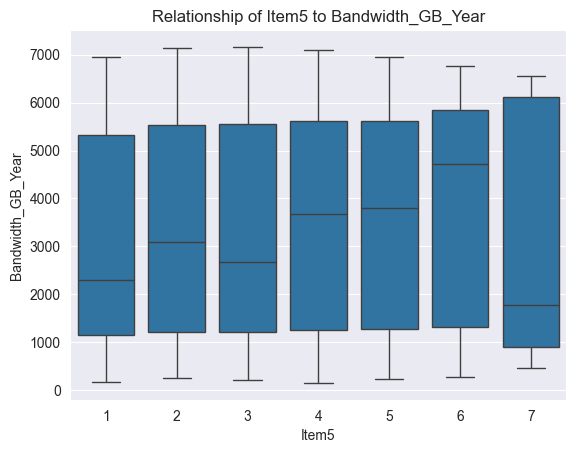

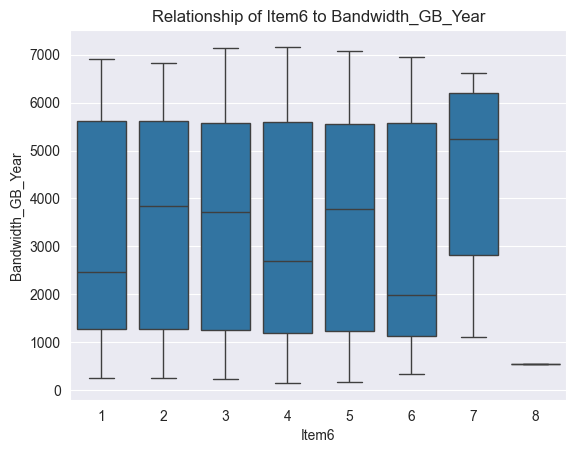

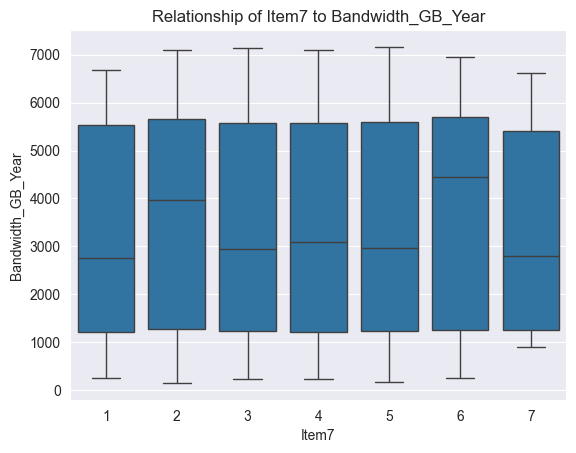

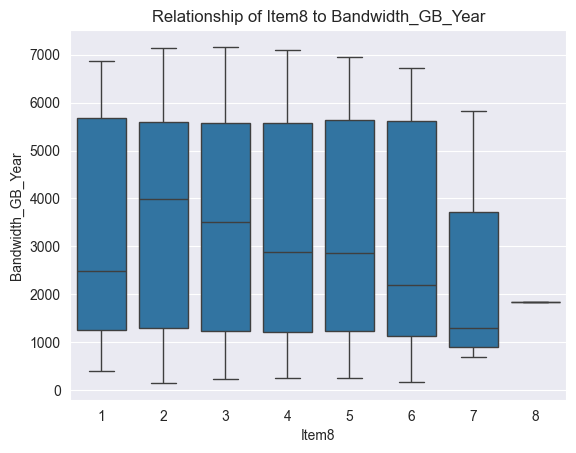

In [13]:
# Bivariate categorical
for col in categorical_variables+yes_no_variables+survey_variables :
    sns.boxplot(data=df, x=col, y=y[0])
    plt.title(f'Relationship of {col} to {y[0]}')
    plt.show()

## Transformation
---

In [14]:
# Reexpress yes/no columns as numbers [In-Text Citation:(Eiler, 2017)]
yesno_dict = {'No': 0, 'Yes': 1}
for col in yes_no_variables:
    df[col] = df[col].map(yesno_dict)
df[yes_no_variables].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Techie            10000 non-null  int64
 1   Port_modem        10000 non-null  int64
 2   Tablet            10000 non-null  int64
 3   Phone             10000 non-null  int64
 4   Multiple          10000 non-null  int64
 5   OnlineSecurity    10000 non-null  int64
 6   OnlineBackup      10000 non-null  int64
 7   DeviceProtection  10000 non-null  int64
 8   TechSupport       10000 non-null  int64
 9   StreamingTV       10000 non-null  int64
 10  StreamingMovies   10000 non-null  int64
dtypes: int64(11)
memory usage: 859.5 KB


In [15]:
# Reexpress survey responses so that 1 is worst and 8 is best
survey_dict = {1: 8, 2: 7, 3 : 6, 4: 5, 5: 4, 6: 3, 7 : 2, 8 : 1}
for col in survey_variables:
    df[col] = df[col].map(survey_dict)

In [16]:
# One-hot encoding
for feature in ['Gender','Marital'] :
    dummies = pd.get_dummies(df[feature], drop_first=True, prefix=feature, dtype=np.int64)
    print(dummies.info())
    X_full.remove(feature)
    for newcol in dummies.columns :            
        X_full.append(newcol)
    df = pd.concat([df, dummies], axis=1).drop(feature, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Gender_Male       10000 non-null  int64
 1   Gender_Nonbinary  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Marital_Married       10000 non-null  int64
 1   Marital_NeverMarried  10000 non-null  int64
 2   Marital_Separated     10000 non-null  int64
 3   Marital_Widowed       10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB
None


In [17]:
# Check for feature colliniarity and drop high VIFs [In-Text Citation: (Prashant, 2016)]
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    X = X.assign(const=1)
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # always preserve the constant
        maxvif = np.max(vif)
        maxloc = vif.index(maxvif)
        if maxvif > thresh:
            print(f'dropping {X.iloc[:, variables].columns[maxloc]:30} at index: {str(maxloc)} with VIF: {maxvif:.5f}')
            del variables[maxloc]
            dropped = True

    return X.iloc[:, variables[:-1]], X.columns[variables[:-1]]

tmp_df, X_full = calculate_vif(df[X_full],5.0)
# Merge post VIF reduction df with the target variable from the df
df = pd.concat([tmp_df, df[y]], axis=1) 

dropping MonthlyCharge                  at index: 5 with VIF: 7.39557


In [18]:
# Extract prepared data set to CSV
df[X_full].info()
df[X_full].to_csv('churn_prepared.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  int64  
 1   Income                10000 non-null  float64
 2   Children              10000 non-null  int64  
 3   Tenure                10000 non-null  float64
 4   Outage_sec_perweek    10000 non-null  float64
 5   Techie                10000 non-null  int64  
 6   Port_modem            10000 non-null  int64  
 7   Tablet                10000 non-null  int64  
 8   Phone                 10000 non-null  int64  
 9   Multiple              10000 non-null  int64  
 10  OnlineSecurity        10000 non-null  int64  
 11  OnlineBackup          10000 non-null  int64  
 12  DeviceProtection      10000 non-null  int64  
 13  TechSupport           10000 non-null  int64  
 14  StreamingTV           10000 non-null  int64  
 15  StreamingMovies     

## Modeling
---

### Full model

In [19]:
# Construct "kitchen sink" multiple linear regression model with no interactions
formula='Bandwidth_GB_Year ~ '
first = True
for col in X_full :
    if first :
        first = False
    else :
        formula += ' + '
    formula += col

print(formula)
mdl_full = smf.ols(formula = formula, data = df).fit()
print(mdl_full.summary())

Bandwidth_GB_Year ~ Age + Income + Children + Tenure + Outage_sec_perweek + Techie + Port_modem + Tablet + Phone + Multiple + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Item1 + Item2 + Item3 + Item4 + Item5 + Item6 + Item7 + Item8 + Gender_Male + Gender_Nonbinary + Marital_Married + Marital_NeverMarried + Marital_Separated + Marital_Widowed
                            OLS Regression Results                            
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.991e+04
Date:                Tue, 18 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:17:45   Log-Likelihood:                -67100.
No. Observations:               10000   AIC:                         1.343e+05
Df Residuals:                    9969   BIC:      

MODEL FIT METRICS:
R2      = 0.99174
R2-adj  = 0.99172
MSE     = 39549.12873
RSE     = 198.86963
x̄ resid = 0.00000


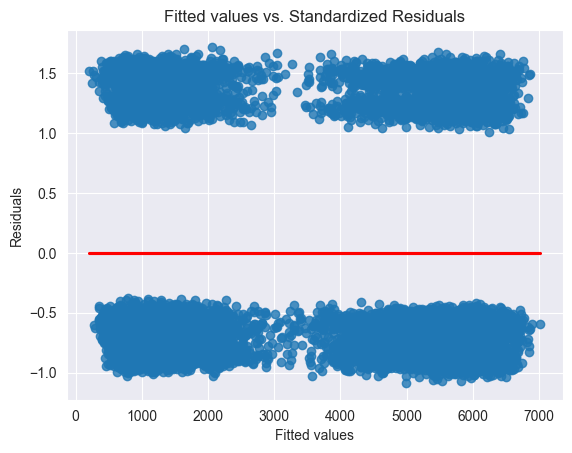

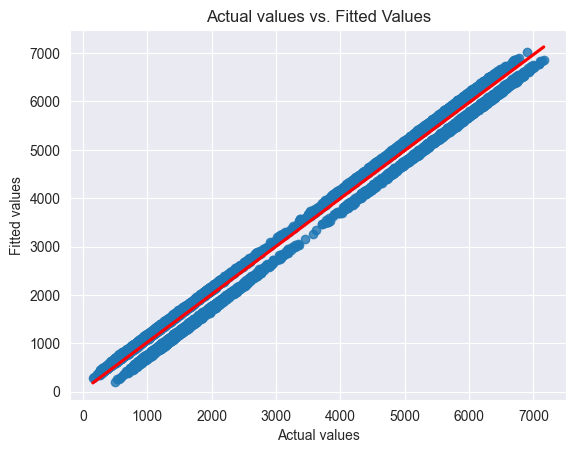

In [20]:
def model_fit_statistics (model_name, model, actual_y) :
    model_results = {'model': model_name, 
                     'r2': model.rsquared, 
                     'r2-adj': model.rsquared_adj, 
                     'mse': model.mse_resid,
                     'rse': np.sqrt(model.mse_resid), 
                     'resid_mean': np.mean(model.resid)}

    print('MODEL FIT METRICS:')
    print(f'R2      = {model_results["r2"]:.5f}')
    print(f'R2-adj  = {model_results["r2-adj"]:.5f}')
    print(f'MSE     = {model_results["mse"]:.5f}')
    print(f'RSE     = {model_results["rse"]:.5f}')
    print(f'x̄ resid = {model_results["resid_mean"]:.5f}')

    std_resid = (model.resid-model.resid.mean())/model.resid.std()

    sns.regplot(x=model.fittedvalues, y=std_resid, data=None, ci=None, line_kws={"color": "red"})
    plt.title('Fitted values vs. Standardized Residuals')
    plt.xlabel ('Fitted values')
    plt.ylabel ('Residuals')
    plt.show()

    sns.regplot(x=actual_y, y=model.fittedvalues, data=None, ci=None, line_kws={"color": "red"})
    plt.title('Actual values vs. Fitted Values')
    plt.xlabel ('Actual values')
    plt.ylabel ('Fitted values')
    plt.show()

    return model_results

mdl_full_results = model_fit_statistics('Full', mdl_full, df[y])

### Feature reduction

In [21]:
# Iteratively remove features with p-values above an acceptable value [In-Text Citation: (Vijayakumar, 2019)]
def backward_elimination(X, y, threshold_out, verbose=False):
    included=list(X.columns)

    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature:30} with p-value {worst_pval:.5f}')
        if not changed:
            break
    print(included)
    return X[included], included

tmp_df, X_reduced = backward_elimination(df[X_full], df[y], 0.045, True) # Lowered pvalue to 0.45 to drop borderline feature 'income'
df_reduced = pd.concat([tmp_df, df[y]], axis=1) # Merge post feature reduction df with the target variable from the df
df_reduced.info()

Drop Tablet                         with p-value 0.96684
Drop Item3                          with p-value 0.76076
Drop Item7                          with p-value 0.76581
Drop Phone                          with p-value 0.71534
Drop Item4                          with p-value 0.69104
Drop Item6                          with p-value 0.64350
Drop Techie                         with p-value 0.59064
Drop Port_modem                     with p-value 0.56639
Drop Marital_Married                with p-value 0.43310
Drop Marital_NeverMarried           with p-value 0.29021
Drop Marital_Separated              with p-value 0.24810
Drop Outage_sec_perweek             with p-value 0.19840
Drop Marital_Widowed                with p-value 0.17406
Drop Item2                          with p-value 0.11885
Drop Item5                          with p-value 0.10694
Drop Gender_Nonbinary               with p-value 0.07244
Drop Item1                          with p-value 0.06238
Drop Item8                     

### Reduced model

In [22]:
# Construct reduced multiple linear regression model with no interactions
formula='Bandwidth_GB_Year ~ '
first = True
for col in X_reduced :
    if first :
        first = False
    else :
        formula += ' + '
    formula += col

print(formula)
mdl_reduced = smf.ols(formula = formula, data = df).fit()
print(mdl_reduced.summary())

Bandwidth_GB_Year ~ Age + Children + Tenure + Multiple + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Gender_Male
                            OLS Regression Results                            
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.088e+05
Date:                Tue, 18 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:17:46   Log-Likelihood:                -67113.
No. Observations:               10000   AIC:                         1.343e+05
Df Residuals:                    9988   BIC:                         1.343e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err      

MODEL FIT METRICS:
R2      = 0.99172
R2-adj  = 0.99171
MSE     = 39577.14192
RSE     = 198.94005
x̄ resid = 0.00000


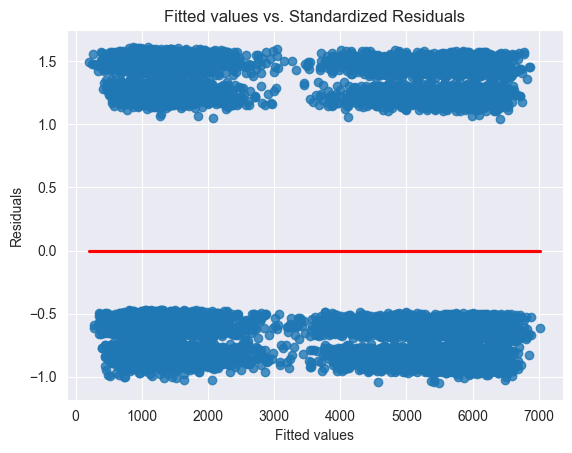

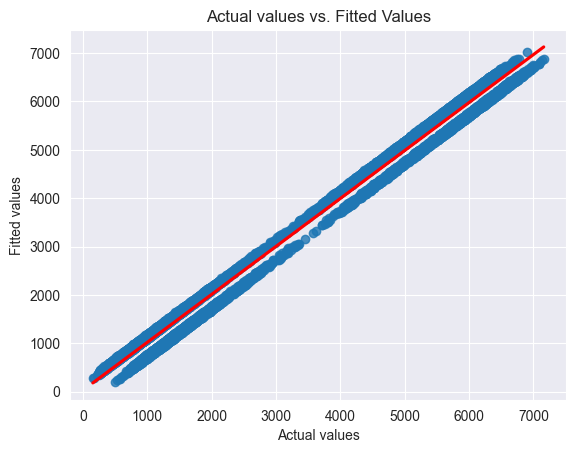

In [23]:
mdl_reduced_results = model_fit_statistics('Reduced', mdl_reduced, df[y])

### Model Comparison

In [27]:
from tabulate import tabulate  # [In-Text Citation: (Astinin, 2022)]

table_data = pd.DataFrame.from_dict([mdl_full_results, mdl_reduced_results])
print(tabulate(table_data, headers="keys", tablefmt="fancy_outline", floatfmt=".5f", showindex=False))
print(f'\nmdl_reduced.resid > 0: {sum(1 for x in mdl_reduced.resid if float(x) > 0.0)}')
print(f'mdl_reduced.resid < 0: {sum(1 for x in mdl_reduced.resid if float(x) < 0.0)}')

╒═════════╤═════════╤══════════╤═════════════╤═══════════╤══════════════╕
│ model   │      r2 │   r2-adj │         mse │       rse │   resid_mean │
╞═════════╪═════════╪══════════╪═════════════╪═══════════╪══════════════╡
│ Full    │ 0.99174 │  0.99172 │ 39549.12873 │ 198.86963 │      0.00000 │
│ Reduced │ 0.99172 │  0.99171 │ 39577.14192 │ 198.94005 │      0.00000 │
╘═════════╧═════════╧══════════╧═════════════╧═══════════╧══════════════╛

mdl_reduced.resid > 0: 3463
mdl_reduced.resid < 0: 6537
